In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
import time
#%matplotlib inline

In [2]:
PATH= "../MobileNet-samples/"
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
bench_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=1,
                                                                 image_size=IMG_SIZE)
class_names = train_dataset.class_names

print(class_names)  
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
['bobcat', 'cat']
Number of validation batches: 26
Number of test batches: 6


2022-05-06 02:55:51.437924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 02:55:51.467892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 02:55:51.468044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 02:55:51.468473: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False

# Let's take a look at the base model architecture
# base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model.summary()   
print(len(model.trainable_variables))

initial_epochs = 5


history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

2022-05-06 02:55:53.025437: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303


(32, 7, 7, 1280)
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                             

2022-05-06 02:55:53.802725: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


(32, 1280)
(32, 1)
2
Epoch 1/15
94/94 [==============================] - 4s 30ms/step - loss: 0.6411 - accuracy: 0.6177 - val_loss: 0.5058 - val_accuracy: 0.8045
Epoch 2/15
94/94 [==============================] - 2s 24ms/step - loss: 0.3930 - accuracy: 0.8320 - val_loss: 0.3483 - val_accuracy: 0.9480
Epoch 3/15
94/94 [==============================] - 2s 23ms/step - loss: 0.2823 - accuracy: 0.9017 - val_loss: 0.2661 - val_accuracy: 0.9678
Epoch 4/15
94/94 [==============================] - 2s 24ms/step - loss: 0.2203 - accuracy: 0.9353 - val_loss: 0.2144 - val_accuracy: 0.9777
Epoch 5/15
94/94 [==============================] - 2s 23ms/step - loss: 0.1819 - accuracy: 0.9493 - val_loss: 0.1790 - val_accuracy: 0.9790
Epoch 6/15
94/94 [==============================] - 2s 24ms/step - loss: 0.1612 - accuracy: 0.9507 - val_loss: 0.1648 - val_accuracy: 0.9777
Epoch 7/15
94/94 [==============================] - 2s 24ms/step - loss: 0.1448 - accuracy: 0.9573 - val_loss: 0.1419 - val_accuracy:

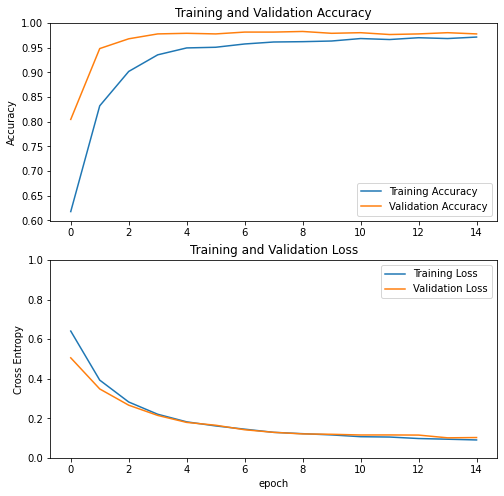

In [4]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()                    

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [8]:
len(model.trainable_variables)

2

In [9]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 15/30
94/94 [==============================] - 4s 29ms/step - loss: 0.0902 - accuracy: 0.9700 - val_loss: 0.0940 - val_accuracy: 0.9814
Epoch 16/30
94/94 [==============================] - 2s 24ms/step - loss: 0.0795 - accuracy: 0.9707 - val_loss: 0.1054 - val_accuracy: 0.9765
Epoch 17/30
94/94 [==============================] - 2s 24ms/step - loss: 0.0910 - accuracy: 0.9683 - val_loss: 0.1001 - val_accuracy: 0.9777
Epoch 18/30
94/94 [==============================] - 2s 24ms/step - loss: 0.0843 - accuracy: 0.9713 - val_loss: 0.1016 - val_accuracy: 0.9777
Epoch 19/30
94/94 [==============================] - 2s 24ms/step - loss: 0.0830 - accuracy: 0.9713 - val_loss: 0.0929 - val_accuracy: 0.9814
Epoch 20/30
94/94 [==============================] - 2s 23ms/step - loss: 0.0879 - accuracy: 0.9700 - val_loss: 0.0993 - val_accuracy: 0.9790
Epoch 21/30
94/94 [==============================] - 2s 23ms/step - loss: 0.0837 - accuracy: 0.9720 - val_loss: 0.0987 - val_accuracy: 0.9765
Epoch 

In [10]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

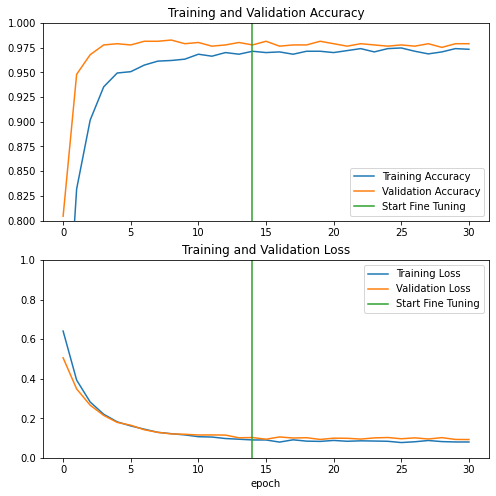

In [11]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [12]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 0s 16ms/step - loss: 0.0812 - accuracy: 0.9844
Test accuracy : 0.984375


Predictions:
 [1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 0]
Labels:
 [1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 0]


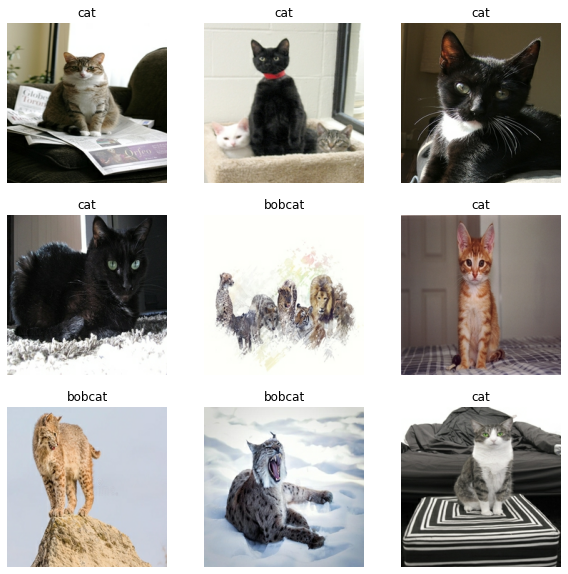

In [13]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model_basic.tflite', 'wb') as f:
  f.write(tflite_model)

2022-05-06 02:57:12.758435: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpvq7l8831/assets


2022-05-06 02:57:25.571989: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-05-06 02:57:25.572020: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-05-06 02:57:25.572628: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpvq7l8831
2022-05-06 02:57:25.600408: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-05-06 02:57:25.600448: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpvq7l8831
2022-05-06 02:57:25.690750: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-05-06 02:57:26.025967: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpvq7l8831
2022-05-06 02:57:26.171890: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 599263 

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()

# Save the model.
with open('model_dr_quant.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpb42au4tl/assets


INFO:tensorflow:Assets written to: /tmp/tmpb42au4tl/assets
2022-05-06 02:57:44.580716: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-05-06 02:57:44.580756: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-05-06 02:57:44.580972: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpb42au4tl
2022-05-06 02:57:44.610661: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-05-06 02:57:44.610693: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpb42au4tl
2022-05-06 02:57:44.707285: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-05-06 02:57:45.060317: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpb42au4tl
2022-05-06 02:57:45.213059: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

In [16]:
def representative_data_gen():
  for input_value in train_dataset.take(100):
    # Model has only one input so each data point has one element.
    yield [input_value[0]]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

'''
tflite_model_dr_quant = converter.convert()

# Save the model.
with open('model_int_quant.tflite', 'wb') as f:
  f.write(tflite_model)
'''

INFO:tensorflow:Assets written to: /tmp/tmp6yt4r9h7/assets


INFO:tensorflow:Assets written to: /tmp/tmp6yt4r9h7/assets
/home/icy/anaconda3/envs/lab3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-05-06 02:58:03.727211: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-05-06 02:58:03.727248: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-05-06 02:58:03.727464: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp6yt4r9h7
2022-05-06 02:58:03.756930: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-05-06 02:58:03.756971: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmp6yt4r9h7
2022-05-06 02:58:03.853485: I tensorflow/cc/saved_model/

In [17]:
# import tflite_runtime.interpreter as tflite

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='./model_basic.tflite')
#allocate the tensors
interpreter.allocate_tensors()

# Load TFLite model and allocate tensors.
dr_quant_interpreter = tf.lite.Interpreter(model_path='./model_dr_quant.tflite')
#allocate the tensors
dr_quant_interpreter.allocate_tensors()

# Load TFLite model and allocate tensors.
int_quant_interpreter = tf.lite.Interpreter(model_path='./model_int_quant.tflite')
#allocate the tensors
int_quant_interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [18]:
def evaluate_model(interpreter):
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # Run predictions on every image in the "test" dataset.
  predictions = []
  labels = []
  start = time.time()
  for test_image, test_label in bench_dataset:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    interpreter.set_tensor(input_details[0]['index'], test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.get_tensor(output_details[0]['index'])[0]
    prediction = tf.nn.sigmoid(output)
    prediction = tf.where(prediction < 0.5, 0, 1)
    predictions.append(prediction)
    labels.append(test_label)

  # Compare prediction results with ground truth labels to calculate accuracy.
  end = time.time()
  accurate_count = 0
  for index in range(len(predictions)):
    if predictions[index] == labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(predictions)

  ms = int(100 * (end - start))

  return accuracy, ms

In [19]:
ac, ms = evaluate_model(interpreter)
sz = os.path.getsize('./model_basic.tflite')
print(f'Accuracy: {ac}, Time (ms): {ms}, Size (bytes): {sz}')

Accuracy: 0.967, Time (ms): 1396, Size (bytes): 8872532


In [20]:
ac, ms = evaluate_model(dr_quant_interpreter)
sz = os.path.getsize('./model_dr_quant.tflite')
print(f'Accuracy: {ac}, Time (ms): {ms}, Size (bytes): {sz}')

Accuracy: 0.967, Time (ms): 1424, Size (bytes): 8872532


In [21]:
ac, ms = evaluate_model(int_quant_interpreter)
sz = os.path.getsize('./model_int_quant.tflite')
print(f'Accuracy: {ac}, Time (ms): {ms}, Size (bytes): {sz}')

Accuracy: 0.967, Time (ms): 1404, Size (bytes): 8872532


Unfortunately, mobilenets use unsupported operators and quantization does not work for these models.

In [24]:
from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader
from tflite_model_maker.image_classifier import ModelSpec


image_path = os.getcwd()
image_path = os.path.join(os.path.dirname(image_path), './MobileNet-samples/train')
print(image_path)

cat_data = DataLoader.from_folder(image_path)

trn_data, rst_data = cat_data.split(0.8)
val_data, tst_data = rst_data.split(0.5)

/home/icy/anaconda3/envs/lab3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/icy/Downloads/./MobileNet-samples/train
INFO:tensorflow:Load image with size: 3000, num_label: 2, labels: bobcat, cat.


In [25]:
model = image_classifier.create(trn_data, model_spec=model_spec.get('mobilenet_v2'), validation_data=val_data)

INFO:tensorflow:Retraining the models...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             2257984   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/5


/home/icy/anaconda3/envs/lab3/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
2022-05-06 14:48:18.898250: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303


13/75 [====>.........................] - ETA: 0s - loss: 0.4972 - accuracy: 0.8005

2022-05-06 14:48:19.953572: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


75/75 [==============================] - 5s 22ms/step - loss: 0.3301 - accuracy: 0.9429 - val_loss: 0.2453 - val_accuracy: 0.9767
Epoch 2/5
75/75 [==============================] - 1s 16ms/step - loss: 0.2519 - accuracy: 0.9817 - val_loss: 0.2385 - val_accuracy: 0.9867
Epoch 3/5
75/75 [==============================] - 1s 15ms/step - loss: 0.2427 - accuracy: 0.9900 - val_loss: 0.2377 - val_accuracy: 0.9833
Epoch 4/5
75/75 [==============================] - 1s 17ms/step - loss: 0.2368 - accuracy: 0.9917 - val_loss: 0.2371 - val_accuracy: 0.9833
Epoch 5/5
75/75 [==============================] - 1s 17ms/step - loss: 0.2339 - accuracy: 0.9942 - val_loss: 0.2366 - val_accuracy: 0.9867


In [27]:
config = QuantizationConfig.for_float16()

model.export(export_dir='.', tflite_filename='model_quant_f16.tflite', quantization_config=config)

INFO:tensorflow:Assets written to: /tmp/tmpovlibxh9/assets


INFO:tensorflow:Assets written to: /tmp/tmpovlibxh9/assets
2022-05-06 14:49:18.052623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 14:49:18.052753: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-05-06 14:49:18.052819: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-05-06 14:49:18.053174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 14:49:18.053296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 14:49:18.053404: I t

INFO:tensorflow:Label file is inside the TFLite model with metadata.


2022-05-06 14:49:18.818242: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-05-06 14:49:18.818288: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmpef098rv5/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmpef098rv5/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model_quant_f16.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model_quant_f16.tflite


In [33]:
sz = os.path.getsize('./model_quant_f16.tflite')
acc = model.evaluate_tflite('model_quant_f16.tflite', tst_data)
print(f'Size (bytes): {sz}, Accuracy: {acc["accuracy"]}')

Size (bytes): 4567484, Accuracy: 0.9766666666666667


In [29]:
config = QuantizationConfig.for_int8(representative_data=trn_data)

model.export(export_dir='.', tflite_filename='model_quant.tflite', quantization_config=config)

INFO:tensorflow:Assets written to: /tmp/tmpcz2bnqdv/assets


INFO:tensorflow:Assets written to: /tmp/tmpcz2bnqdv/assets
2022-05-06 14:49:28.118983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 14:49:28.119122: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-05-06 14:49:28.119189: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-05-06 14:49:28.119379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 14:49:28.119511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-06 14:49:28.119619: I t

INFO:tensorflow:Label file is inside the TFLite model with metadata.


fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 3
INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmp01w5mpnq/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmp01w5mpnq/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model_quant.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model_quant.tflite


In [31]:
sz = os.path.getsize('./model_quant.tflite')
acc = model.evaluate_tflite('model_quant.tflite', tst_data)
print(f'Size (bytes): {sz}, Accuracy: {acc["accuracy"]}')

Size (bytes): 2778272, Accuracy: 0.9733333333333334


In [60]:
PATH= "../MobileNet-samples/"
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
BATCH_SIZE = 32
IMG_SIZE = (112, 112)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
bench_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=1,
                                                                 image_size=IMG_SIZE)
class_names = train_dataset.class_names

print(class_names)  
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
['bobcat', 'cat']
Number of validation batches: 26
Number of test batches: 6


In [61]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

IMG_SHAPE = (*IMG_SIZE, 3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False

# Let's take a look at the base model architecture
# base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(112, 112, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model.summary()   
print(len(model.trainable_variables))

initial_epochs = 5

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

(32, 4, 4, 1280)
(32, 1280)
(32, 1)
2
Epoch 1/5
94/94 [==============================] - 3s 17ms/step - loss: 0.7121 - accuracy: 0.6593 - val_loss: 0.4146 - val_accuracy: 0.7995
Epoch 2/5
94/94 [==============================] - 1s 13ms/step - loss: 0.4440 - accuracy: 0.7953 - val_loss: 0.2943 - val_accuracy: 0.9022
Epoch 3/5
94/94 [==============================] - 1s 13ms/step - loss: 0.3251 - accuracy: 0.8577 - val_loss: 0.2403 - val_accuracy: 0.9220
Epoch 4/5
94/94 [==============================] - 1s 13ms/step - loss: 0.2813 - accuracy: 0.8807 - val_loss: 0.2191 - val_accuracy: 0.9245
Epoch 5/5
94/94 [==============================] - 1s 12ms/step - loss: 0.2439 - accuracy: 0.8967 - val_loss: 0.1991 - val_accuracy: 0.9295


In [62]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [63]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [64]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
94/94 [==============================] - 3s 18ms/step - loss: 0.2206 - accuracy: 0.9077 - val_loss: 0.1916 - val_accuracy: 0.9356
Epoch 6/10
94/94 [==============================] - 1s 13ms/step - loss: 0.2343 - accuracy: 0.9013 - val_loss: 0.1805 - val_accuracy: 0.9356
Epoch 7/10
94/94 [==============================] - 1s 14ms/step - loss: 0.2270 - accuracy: 0.9010 - val_loss: 0.1835 - val_accuracy: 0.9307
Epoch 8/10
94/94 [==============================] - 1s 13ms/step - loss: 0.2367 - accuracy: 0.9057 - val_loss: 0.1801 - val_accuracy: 0.9369
Epoch 9/10
94/94 [==============================] - 1s 13ms/step - loss: 0.2142 - accuracy: 0.9113 - val_loss: 0.1944 - val_accuracy: 0.9295
Epoch 10/10
94/94 [==============================] - 1s 13ms/step - loss: 0.2229 - accuracy: 0.9073 - val_loss: 0.1949 - val_accuracy: 0.9332


In [65]:
PATH= "../MobileNet-samples/"
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
BATCH_SIZE = 32
IMG_SIZE = (112, 112)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
bench_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=1,
                                                                 image_size=IMG_SIZE)
class_names = train_dataset.class_names

print(class_names)  
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
['bobcat', 'cat']
Number of validation batches: 26
Number of test batches: 6


In [66]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.mobilenet.preprocess_input

IMG_SHAPE = (*IMG_SIZE, 3,)
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False

# Let's take a look at the base model architecture
# base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(112, 112, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model.summary()   
print(len(model.trainable_variables))

initial_epochs = 5

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

(32, 3, 3, 1024)
(32, 1024)
(32, 1)
2
Epoch 1/5
94/94 [==============================] - 2s 12ms/step - loss: 0.9410 - accuracy: 0.6060 - val_loss: 0.7431 - val_accuracy: 0.6881
Epoch 2/5
94/94 [==============================] - 1s 9ms/step - loss: 0.6576 - accuracy: 0.7097 - val_loss: 0.5648 - val_accuracy: 0.7723
Epoch 3/5
94/94 [==============================] - 1s 9ms/step - loss: 0.4873 - accuracy: 0.7960 - val_loss: 0.4829 - val_accuracy: 0.8020
Epoch 4/5
94/94 [==============================] - 1s 9ms/step - loss: 0.4520 - accuracy: 0.8157 - val_loss: 0.4097 - val_accuracy: 0.8403
Epoch 5/5
94/94 [==============================] - 1s 9ms/step - loss: 0.3829 - accuracy: 0.8397 - val_loss: 0.3807 - val_accuracy: 0.8639


In [67]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  86


In [68]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [69]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
94/94 [==============================] - 2s 12ms/step - loss: 0.3625 - accuracy: 0.8450 - val_loss: 0.3815 - val_accuracy: 0.8651
Epoch 6/10
94/94 [==============================] - 1s 9ms/step - loss: 0.3474 - accuracy: 0.8580 - val_loss: 0.3671 - val_accuracy: 0.8713
Epoch 7/10
94/94 [==============================] - 1s 9ms/step - loss: 0.3533 - accuracy: 0.8540 - val_loss: 0.3715 - val_accuracy: 0.8639
Epoch 8/10
94/94 [==============================] - 1s 9ms/step - loss: 0.3313 - accuracy: 0.8667 - val_loss: 0.3564 - val_accuracy: 0.8725
Epoch 9/10
94/94 [==============================] - 1s 9ms/step - loss: 0.3236 - accuracy: 0.8667 - val_loss: 0.3505 - val_accuracy: 0.8775
Epoch 10/10
94/94 [==============================] - 1s 9ms/step - loss: 0.3201 - accuracy: 0.8647 - val_loss: 0.3449 - val_accuracy: 0.8762


I have chosen to benchmark MobileNetV2 on videos instead, due to supported operations allowing quantization!

In [18]:
model_path = '../trn/model_basic.tflite'
video_path = '../trn/uwu.mp4'
label_path = './label.txt'
filename = '../obj/TFLite_detection_video.py'
args = [f'--modeldir={model_path}', f'--video={video_path}', f'--label={label_path}']

In [19]:
%run $filename {args[0]} {args[1]} {args[2]}

/home/icy/Downloads/trn
Reached the end of the video!
Time (ms): 687.0937347412109


In [16]:
model_path = '../trn/model_int_quant.tflite'
args = [f'--modeldir={model_path}', f'--video={video_path}', f'--label={label_path}']

In [17]:
%run $filename {args[0]} {args[1]} {args[2]}

/home/icy/Downloads/trn
Reached the end of the video!
Time (ms): 669.1932439804077


Slight improvement with integer quantization! Note, most of the overhead is processing the video, as my computer is powerful enough that the TFLite models can run with virtually real-time with no latency. However, a more interesting benchmark would be with a Raspberry Pi or smaller device.